# Analysis of Clusters
The purpose of this analysis is to explore how states might be identified if different clustering techniques are used. The focus is on using the normalized data.

In [1]:
import init
from common import constants as cn
from common.data_provider import DataProvider
from common.data_grouper import DataGrouper
from common import transform_data
from terms.term_matrix import TermMatrix
from plots import util_plots
from common_python.text.term_analyzer import TermAnalyzer
from common_python.text import util_text

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# Initialize the data
provider = DataProvider()
provider.do()

In [3]:
provider.df_normalized.head()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25
GENE_ID,,,,,,,,,,,,,,,,,,,,,
Rv0001,0.0,0.053288,0.562002,0.520098,0.408998,0.292690,0.197589,0.370034,-0.161297,-0.019435,...,0.716156,0.726429,0.999946,-0.779207,-0.772564,-0.506032,1.130520,1.210863,0.795904,0.424219
Rv0005,0.0,0.336807,0.921491,0.857554,0.965708,0.870024,0.932548,1.102305,-0.282280,0.018132,...,0.537108,0.595354,0.593092,-2.044135,-2.142398,-1.892089,-0.090506,0.304769,0.224248,0.551998
Rv0006,0.0,0.366148,0.782390,1.069473,1.040000,0.851552,1.092635,0.919673,-0.664284,-0.196439,...,0.110037,-0.157785,0.399855,-2.097919,-2.057011,-1.771128,-0.241943,0.129194,0.188108,0.467530
Rv0009,0.0,0.755500,1.256562,0.938486,1.124699,0.869502,0.982032,0.963860,-0.797231,-0.089894,...,-0.291450,0.134672,-0.206416,-2.747671,-3.066205,-2.417691,0.060293,0.298611,0.212941,0.408092
Rv0010c,0.0,0.463511,0.526630,0.611111,0.626512,0.424885,0.588894,0.451351,-0.401350,-0.128419,...,-0.361586,-0.408970,-0.403555,-1.160688,-1.212446,-1.003800,-0.267877,-0.042166,-0.003257,0.262309


## Visualization of the Normalized Data

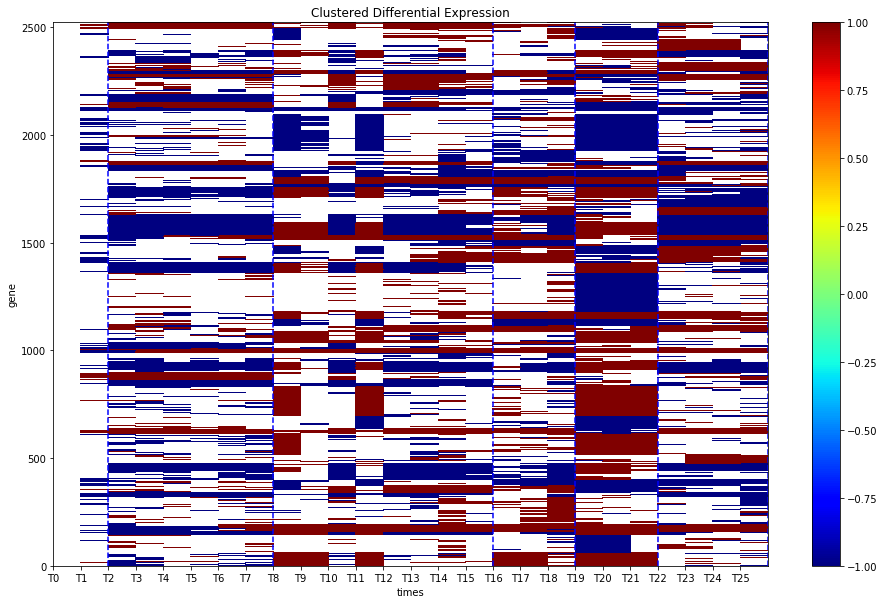

In [4]:
df = util_plots.plotClusteredHeatmap(provider=provider, ncluster=60)

## Perfect Correlations
Perfectly correlated genes are ones that are differentially expressed in the same way at each interval.

In [5]:
df = transform_data.thresholdData(provider.df_normalized, is_include_nan=False)
grouper = DataGrouper(df)
grouper.do(min_size=1)

In [6]:
MAX = 25
probs = []
grouper.do(min_size=0, is_include_zeros=True)
df = grouper.df_group
total = df[cn.CNT_GROUP].sum()
for n in range(0, MAX):
    count = sum([r[cn.CNT_GROUP] for _, r in df.iterrows() if r[cn.CNT_UP] + r[cn.CNT_DOWN] == n])
    probs.append(count)
probs = [1.0*p / total for p in probs]



In [7]:
grouper.do(min_size=0, is_include_zeros=True)
len(grouper.df_group)

1515

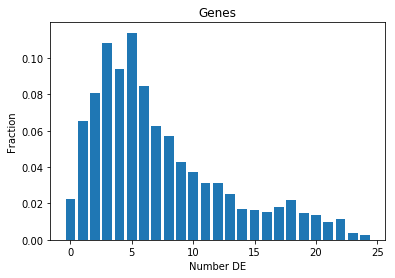

In [8]:
# Hist for the number of genes timepoints with DE
_ = plt.bar(range(len(probs)), probs)
_ = plt.xlabel("Number DE")
_ = plt.ylabel("Fraction")
_ = plt.title("Genes")

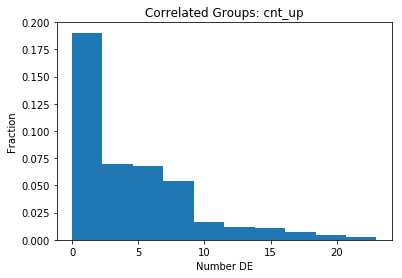

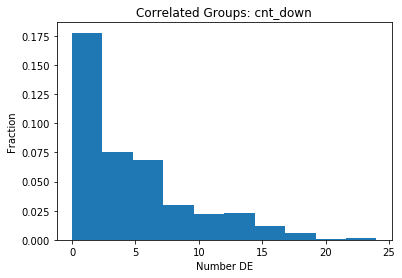

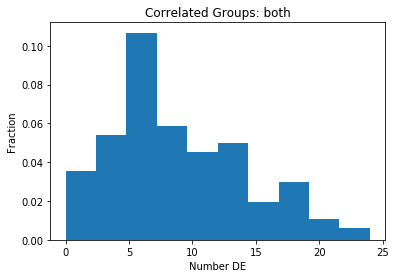

In [9]:
# Histogram for number of groups with differential expression
bins = 10
for col in [cn.CNT_UP, cn.CNT_DOWN, "both"]:
    plt.figure()
    if col == "both":
        _ = plt.hist(grouper.df_group[cn.CNT_UP] + grouper.df_group[cn.CNT_DOWN], density=True, bins=bins)
    else:
        _ = plt.hist(grouper.df_group[col], density=True, bins=bins)
    _ = plt.xlabel("Number DE")
    _ = plt.ylabel("Fraction")
    _ = plt.title("Correlated Groups: %s" % col)

In [10]:
# CDF of group sizes
def plotGroupSizeCDF(min_size):
    grouper.do(min_size=min_size)
    cnts = grouper.df_group[cn.CNT_GROUP].tolist()
    cnts.sort()
    frac = [1.0*i/len(cnts) for i in range(len(cnts))]
    _ = plt.plot(cnts, frac)
    _ = plt.xlabel("Group Size")
    _ = plt.ylabel("Fraction")

In [11]:
# CDF of group sizes
def plotGroupSizeHist(min_size):
    grouper.do(min_size=min_size)
    cnts = grouper.df_group[cn.CNT_GROUP].tolist()
    plt.hist(cnts, bins=len(grouper.df_group))
    _ = plt.xlabel("Group Size")
    _ = plt.ylabel("# Groups")
    _ = plt.title("Min. Group Size: %d" % min_size)

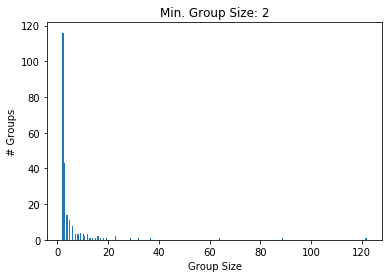

In [12]:
plotGroupSizeHist(2)

In [13]:
grouper.do(min_size=1)
grouper.df_group[cn.CNT_GROUP].sum()

2524

In [14]:
grouper.do(min_size=3)
1464 - grouper.df_group[cn.CNT_GROUP].sum()

460

In [15]:
2772-1464

1308

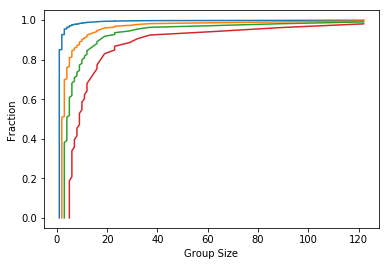

In [16]:
for size in [1, 2, 3, 5]:
    plotGroupSizeCDF(size)

In [17]:
from scipy.stats import binom
binom.cdf(0, 10, 0.047)

0.6179153819690496

In [18]:
len(provider.df_normalized)

2582

**Observations**
1. What's going on with the block of genes that are solid blue? Should be 0s? 
Some genes remain over- or under- expressed across multiple state transitions
1. Also, seem to be mini-states
1. It looks like there's a solid band around 2300. This seems impossible since the high values must be compensated by low values relative to the mean.
1. Note the juxtaposition of over-expression with under-expression. What are these genes?

**Analyses**
1. Validate against Mario's data
1. Find perfectly correlated genes, plot statistics on groups.
1. Create a spreadsheet with groups, genes, GO terms
1. Fit frequency of groups with n DEs to a discrete exponential?
1. Plot number or fraction of >1 in succession DEs over time with vertical lines before looking at statistical tests.
1. Overlay the groups on time.

## Gene Analysis

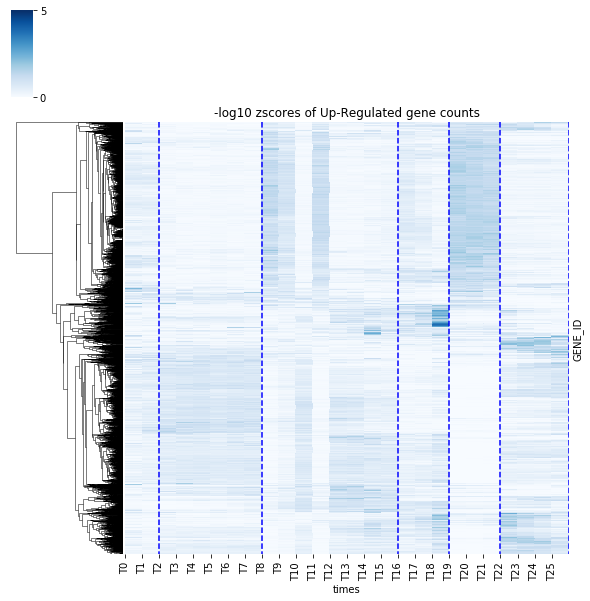

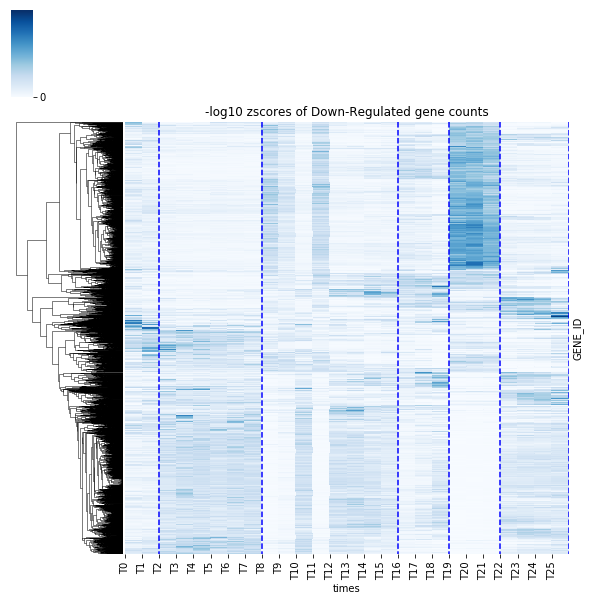

In [19]:
util_plots.plotClustermap()
util_plots.plotClustermap(is_up_regulated=False)

## Term Analysis

In [20]:
matrix = TermMatrix()

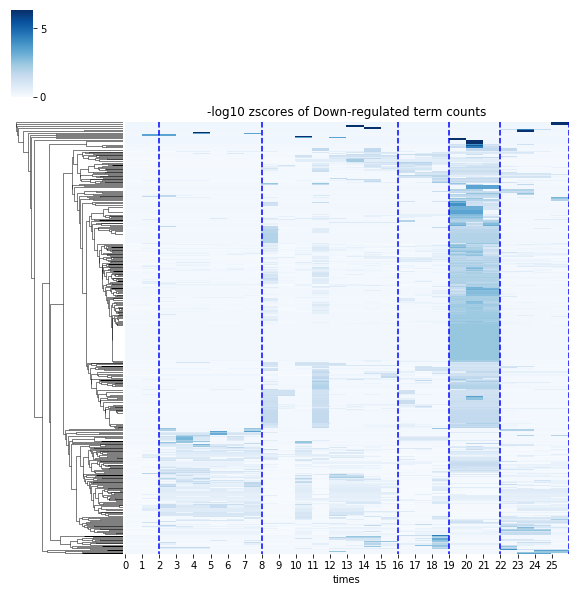

In [21]:
matrix.plotTimeAggregation(is_up_regulated=False)

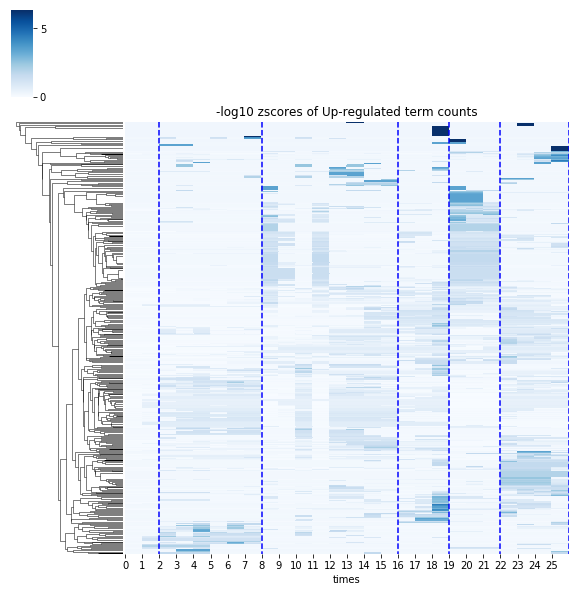

In [22]:
matrix.plotTimeAggregation(is_up_regulated=True)

In [23]:
_, _, ser_cluster = matrix.calcClusters(max_distance=0, is_up_regulated=True)

In [29]:
ser_cluster.sort_values()

entry of bacterium into host cell                                                      1
adhesion of symbiont to host cell                                                      1
NAD+ binding                                                                           1
inositol phosphate dephosphorylation                                                   2
inositol metabolic process                                                             2
cellular response to nitrate                                                           2
cellular response to decreased oxygen levels                                           2
intracellular                                                                          2
growth involved in symbiotic interaction                                               2
leucine biosynthetic process                                                           2
oxaloacetate metabolic process                                                         2
nitrate reductase act

In [24]:
df = pd.DataFrame({'group': ser_cluster, 'term': ser_cluster.index})
dfg = df.groupby('group')
groups = dfg.groups
terms = ["\n".join(v.tolist()) for v in groups.values()]
sizes = [len(v.tolist()) for v in groups.values()]
df_g = pd.DataFrame({'group': list(groups.keys()), 'terms': terms, 'sizes': sizes})

In [25]:
df_g.to_csv("terms.csv")

In [26]:
len(groups.keys())

361

In [27]:
type(groups)

dict

**Notes**:
1. Am I seeing all of the GO terms?

## Gene and Terms

Analysis
1. Plot number times regulated versus ratio of term count / gene count for groups